# LSTM timeseries forecasting with Keras Tuner
> A example of using an LSTM network to forecast timeseries, using Keras Tuner for hyperparameters tuning.

- toc: true 
- badges: true
- comments: true
- categories: [lstm, keras, keras tuner, python, machine learning, timeseries]
- image: images/2021-05-31-LSTM timeseries forecasting with Keras Tuner-MAIN.jpg

# About

This project is a demonstration of some of capabilities of [Keras Tuner](https://github.com/keras-team/keras-tuner). This project is an attempt to use an `LSTM` based neural network (RNN) to forecast `timeseries` data.

## The required libraries

Import the `must-have` libraries:

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

Import the elements required from the `scikit-learn` library:

In [2]:
import sklearn as sk
import sklearn.preprocessing as skp
import sklearn.model_selection as skms
import sklearn.pipeline as skpl
import sklearn.decomposition as skd
import sklearn.linear_model as sklm
import sklearn.dummy as sky
import sklearn.metrics as skme

Enables defining partial functions:

In [3]:
from functools import partial

Import the `keras` elements from the `tensorflow` library:

In [4]:
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import backend as kb
from tensorflow.keras import callbacks as kc
from tensorflow.keras import models as km
from tensorflow.keras import layers as kl
from tensorflow.keras import regularizers as kr
from tensorflow.keras import optimizers as ko
from tensorflow.keras import utils as ku

Import the `keras-tuner` library as we'll use it to tune `hyperparameters`:

In [5]:
import kerastuner as kt
from kerastuner import tuners as ktt

Import `matplotlib` and set the default magic:

In [6]:
import matplotlib as mat
from matplotlib import pyplot as plt
import pylab as pyl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Import the `mlviz` library used to plot `time-series` visualizations:

In [7]:
from mlviz.timeseries import visualizationhelpers as mwvh
from mlviz.utilities import graphichelpers as mwgh

## The project parameters

Reset the predefined `matplotlib` style:

In [8]:
mwgh.GraphicsStatics.initialize_matplotlib_styles()

Here is the **color palette** we'll use for the project:

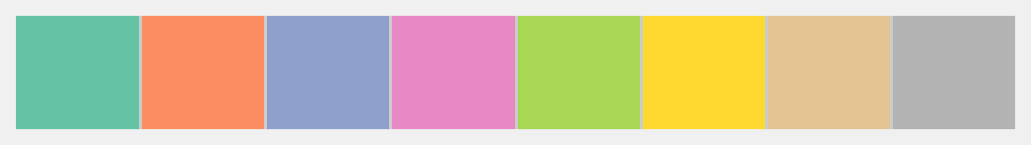

In [9]:
sns.palplot(mwgh.GraphicsStatics.g_palette)

Let's capture all the usefull project's **parameters** in a dictionary:

In [10]:
params = {}

params['project_date'] = '2021-05-31'
params['project_name'] = 'LSTM timeseries forecasting with Keras Tuner-DATA'
params['experiment_name'] = '{0}-{1}'.format(params['project_date'], params['project_name'])
params['data_frequency'] = 'W-SAT'
params['features'] = ['y']

params['input_size'] = 52          # N weeks of data to input into the network
params['output_size'] = 13         # N weeks of data to output from the network
params['testing_size'] = 52        # N weeks of data to keep for testing the model
params['lag_size'] = [13, 26, 39]  # Lagged data series injected into the network

params['hyperband_iterations'] = 3
params['max_epochs'] = 100
params['patience'] = 20
params['batch_size'] = 16

## The timeseries data

The input data is available in a `csv` file named `2021-05-31-LSTM timeseries forecasting with Keras Tuner-DATA.csv` located in the `data` folder. It has got 2 columns `date` containing the date of event and `value` holding the value of the source. We'll rename these 2 columns as `ds` and `y` for convenience. Let's load the `csv` file using the `pandas` library and have a look at the data.

In [11]:
df = pd.read_csv(
    filepath_or_buffer='../assets/data/{0}.csv'.format(
        params['experiment_name']),
    sep=';')

df.rename(
    columns = {
        'date': 'index',
        'value': 'y'
    }, 
    inplace=True)

df['index'] = pd.to_datetime(
    arg=df['index'], 
    dayfirst=True)

df.sort_values(
    by='index', 
    ascending=True,
    inplace=True)

df.set_index(
    keys='index', 
    inplace=True)

df = df.asfreq(
    freq=params['data_frequency'])

df['ds'] = df.index

print('df.shape = {0}'.format(df.shape))

df.tail(5)

df.shape = (625, 2)


,y,ds
index,,
2019-09-28,5547,2019-09-28
2019-10-05,6459,2019-10-05
2019-10-12,5838,2019-10-12
2019-10-19,5894,2019-10-19
2019-10-26,7925,2019-10-26


### Prepare data for the network

It is time to prepare the dataset to feed into the LSTM network. We'll use 4 features as input: the current data point as well as 3 additional data points from respectively 13, 26 and 39 weeks before the current datapoint. 

![](images/lstm-data.jpg)

It's easy to calculate the _width_ of a sample:

In [12]:
sample_width = max(params['lag_size']) + params['input_size'] + params['output_size']
print('sample_width: {0}'.format(sample_width))

sample_width: 104


To avoid any overlap between the `training` and the `testing` data set, we'll first split the dataframes, keeping `params['testing_size']` samples for testing our model. We need to make sure that no data point used for training is also used for testing our model.

In [13]:
threshold_date = pd.to_datetime(df.index[df.shape[0] - (sample_width + params['testing_size'])])
print('Cutoff date for training/testing split is {0}'.format(threshold_date.strftime('%d/%m/%Y')))

Cutoff date for training/testing split is 05/11/2016


Let's cut the dataframe at the right date:

In [14]:
test_mask = (df['ds'] > threshold_date)
df_train = df[~test_mask]
df_test = df[test_mask]
print('df_train.shape = {0}'.format(df_train.shape))
print('df_test.shape = {0}'.format(df_test.shape))

df_train.shape = (470, 2)
df_test.shape = (155, 2)


The `prepare_data` funtion will take care of doing exactly this:

In [15]:
def prepare_data(data, lag_data, cols_in, steps_in, cols_out, steps_out, scaler_in=None, scaler_out=None):
    
    df = data.copy()
    cols_in_original = [col for col in cols_in]
    cols_in_processed = [col for col in cols_in]
    
    steps_lag = 0
    
    if lag_data is not None and len(lag_data) > 0:
        steps_lag = max(lag_data)
        
        for col in cols_in_original:
            for i, lag in enumerate(lag_data):
                lag_col = '{0}_{1}'.format(col, lag)
                df[lag_col] = df[col].shift(lag)
                cols_in_processed.append(lag_col)
        
    samples = df.shape[0] - (steps_in + steps_out + steps_lag) + 1
    
    if samples < 1:
        raise ValueError('not enough data to produce 1 sample.')
    
    index = list(df.index)
    cols_in_indices = {name: i for i, name in enumerate(cols_in_processed)}
    cols_out_indices = {name: i for i, name in enumerate(cols_out)}
    
    df.reset_index(inplace=True)
    
    
    X_input_scaled = None
    
    if scaler_in is None:
        scaler_in = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        X_input_scaled = scaler_in.fit_transform(df[cols_in_processed].values)
    else:
        X_input_scaled = scaler_in.transform(df[cols_in_processed].values)
    
    
    y_output_scaled = None
    
    if scaler_out is None:
        scaler_out = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        y_output_scaled = scaler_out.fit_transform(df[cols_out].values)
    else:
        y_output_scaled = scaler_out.transform(df[cols_out].values)
        
        
    X = []
    y = []
    
    for sample in range(samples):
        for step_in in range(steps_in):
            for col_in in range(len(cols_in_processed)):
                X.append(X_input_scaled[sample+steps_lag+step_in, col_in])
        for step_out in range(steps_out):
            for col_out in range(len(cols_out)):
                y.append(y_output_scaled[sample+steps_lag+steps_in+step_out, col_out])
    
    X = np.array(X).reshape(samples, steps_in, len(cols_in_processed))
    y = np.array(y).reshape(samples, steps_out, len(cols_out))
    
    return X, y, index, scaler_in, scaler_out, cols_in_indices, cols_out_indices

Every intput feature (passed via the function parameter `cols_in`) is going to be rescalled using a `scikit-learn` pipeline containing first a `StandardScaler` and then a `MinMaxScaler` in order to end up with a feature range of `[-1, +1]` required by neural networks.

In [16]:
X_train, y_train, index_train, scaler_in, scaler_out, cols_in_indices_train, cols_out_indices_train = prepare_data(
    data=df_train,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'])

print('X_train.shape: {0}'.format(X_train.shape))
print('y_train.shape: {0}'.format(y_train.shape))

X_train.shape: (367, 52, 4)
y_train.shape: (367, 13, 1)


To prepare the `testing` data, we need to reuse both **input** (variable `scaler_in`) and **output** (variable `scaler_out`) pipelines in order to keep data scaled in the same way.

In [17]:
X_test, y_test, index_test, _, _, cols_in_indices_test, cols_out_indices_test = prepare_data(
    data=df_test,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'],
    scaler_in=scaler_in, 
    scaler_out=scaler_out)

print('X_test.shape: {0}'.format(X_test.shape))
print('y_test.shape: {0}'.format(y_test.shape))

X_test.shape: (52, 52, 4)
y_test.shape: (52, 13, 1)


### Data visualization

Let's have a look at the visual representation of the timeseries data:

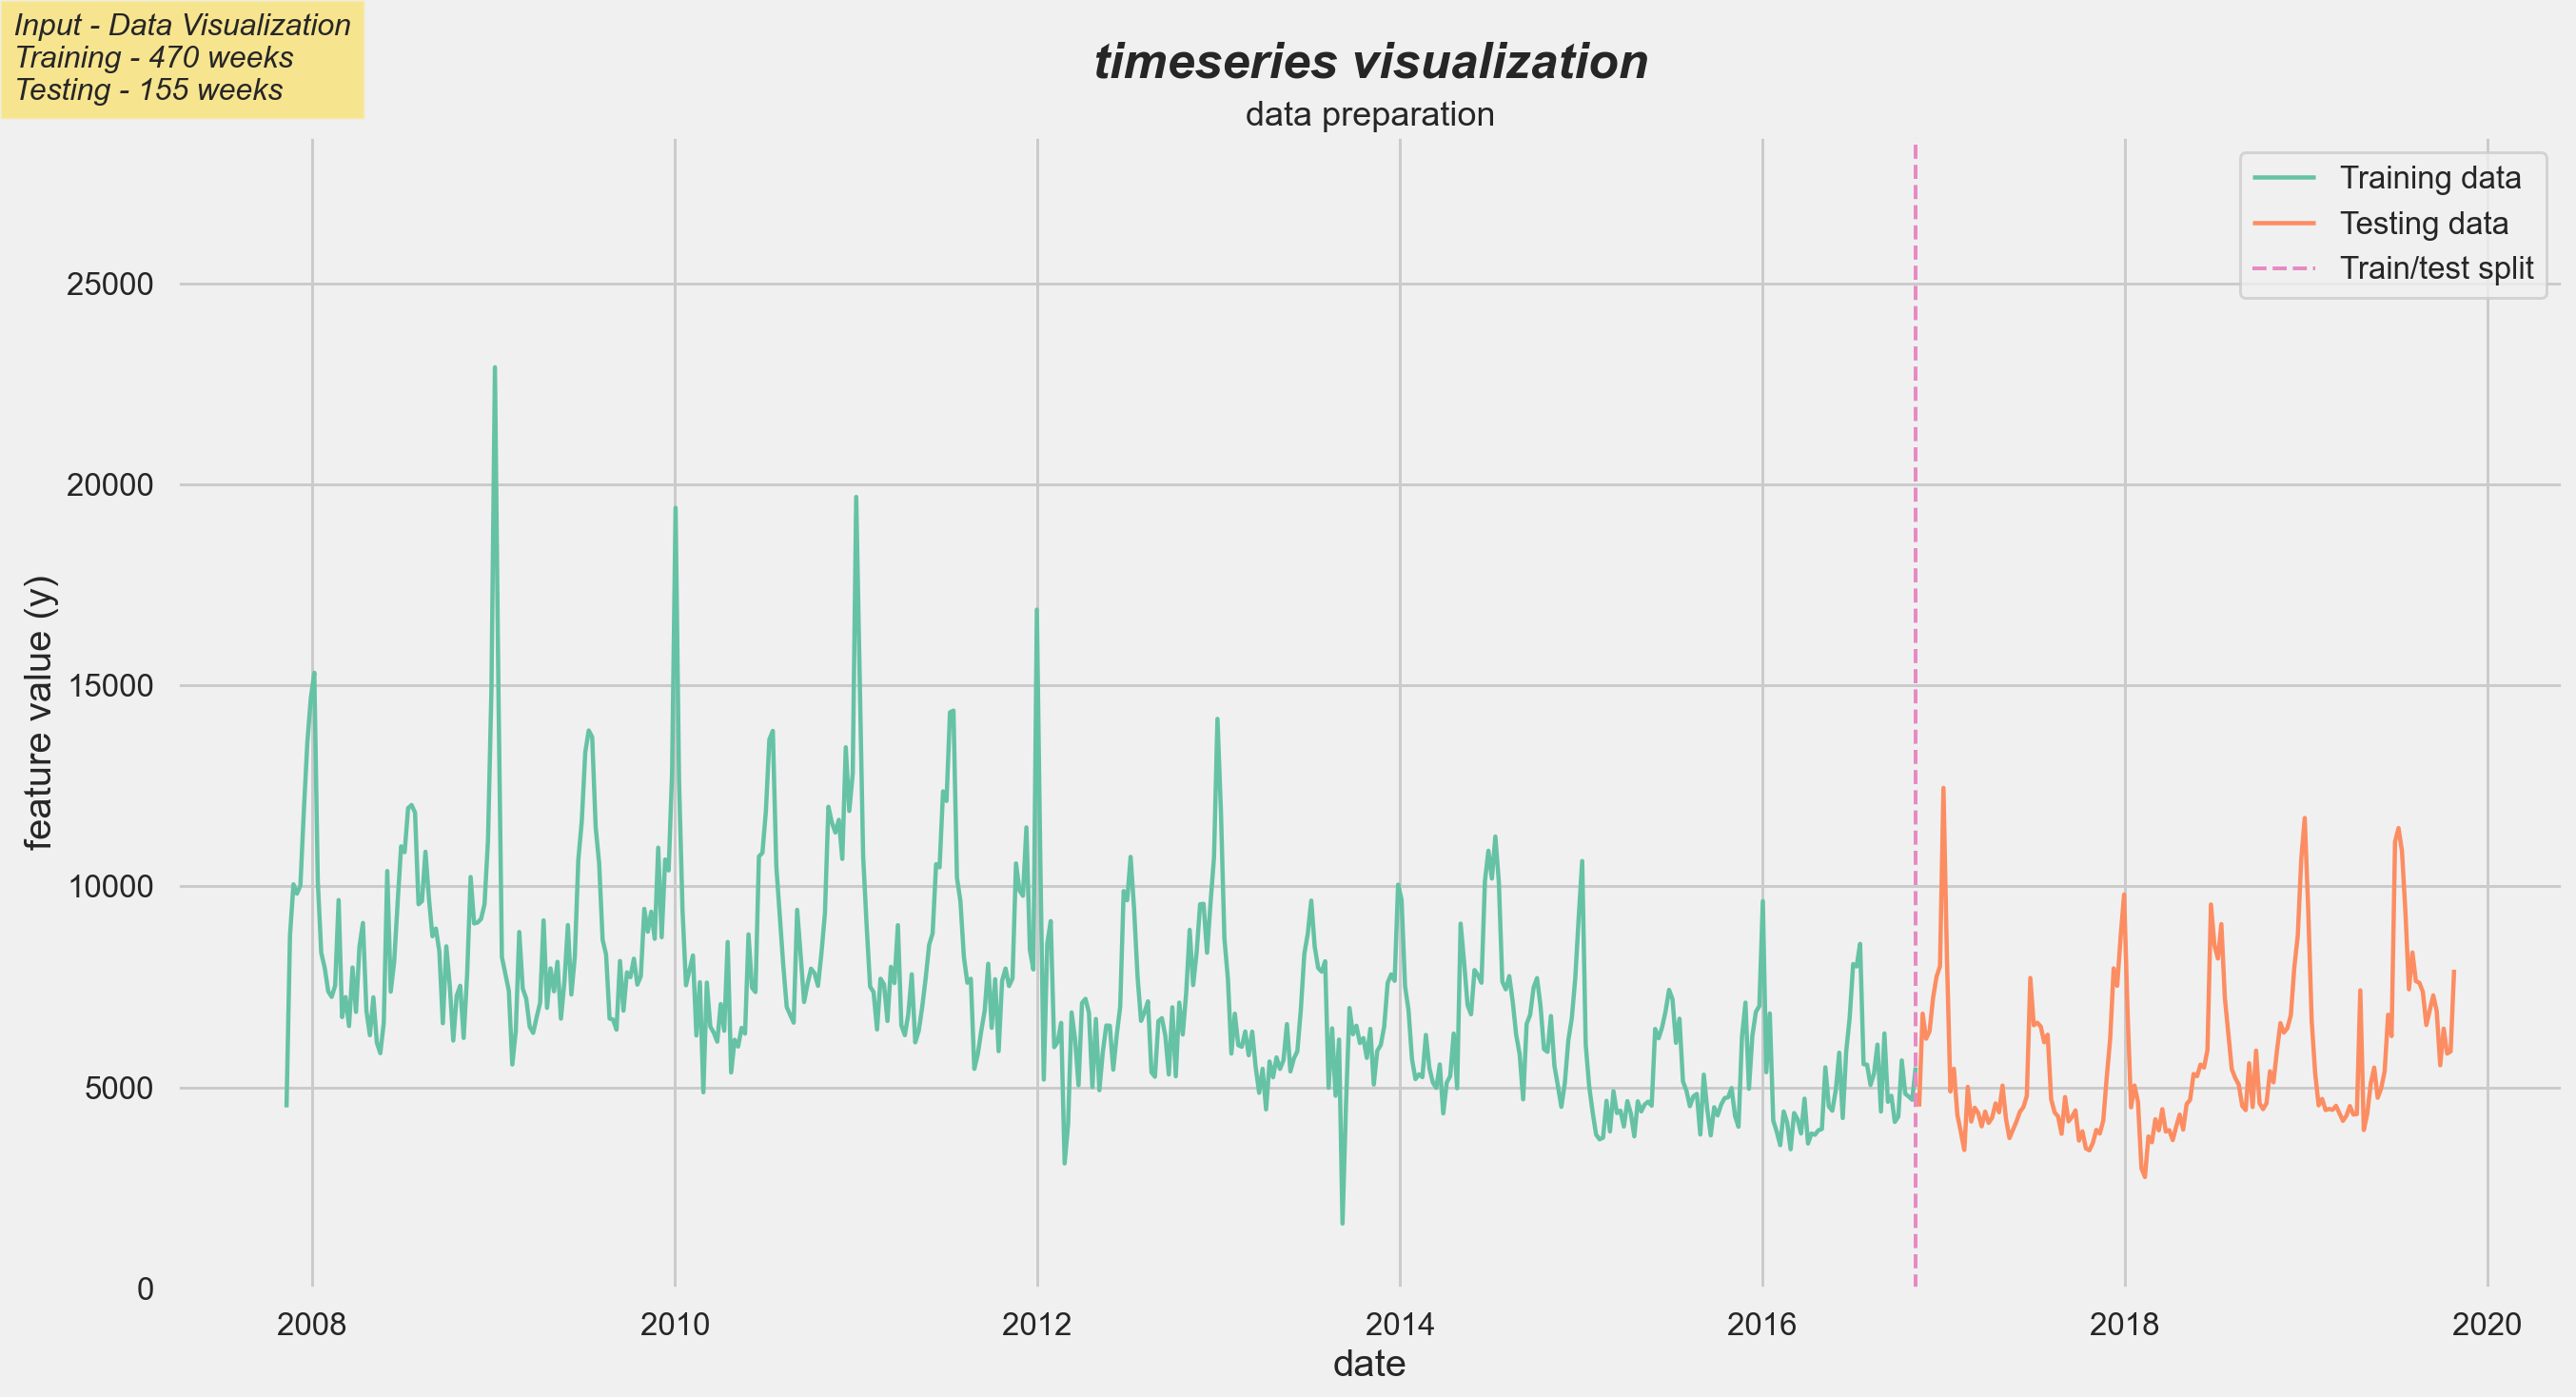

In [18]:
mwvh.plot_time_series(
    title='timeseries visualization',
    subtitle='data preparation',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    ylabel='feature value (y)',
    split=threshold_date)

## Build the model

### Hyperparameters space definition

We'll use `RMSE` as our loss function to optimize (it is required to be defined as a function that can be compiled by `TensorFlow`):

In [19]:
def rmse(y_true, y_pred):
    return tf.cast(
        tf.sqrt(
            tf.reduce_mean(
                tf.square(
                    tf.subtract(
                        y_pred,
                        y_true)))),
        dtype=tf.float32)

First, we define a model-building function. It takes an argument `hp` from which `Keras-Tuner` can sample hyperparameters:

In [20]:
def build_model_hp(hp, loss_fn, metrics_fn, steps_in, steps_out, n_features):

    # define model
    model = km.Sequential()

    model.add(
        kl.Bidirectional(
            layer=kl.LSTM(
                name='lstm_1',
                kernel_regularizer=kr.l2(
                    l=hp.Float(
                        name='lstm_1_kernel_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                bias_regularizer=kr.l2(
                    l=hp.Float(
                        name='lstm_1_bias_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                units=hp.Int(
                    name='lstm_1_units',
                    min_value=64,
                    max_value=128,
                    step=4), 
                input_shape=(steps_in, n_features),
                dropout=hp.Float(
                    name='lstm_1_dropout',
                    min_value=0.3,
                    max_value=0.5,
                    step=0.1),
                return_sequences=False)))

    model.add(kl.RepeatVector(n=steps_out))

    model.add(
        kl.Bidirectional(
            layer=kl.LSTM(
                name='lstm_2',
                kernel_regularizer=kr.l2(
                    l=hp.Float(
                        name='lstm_2_kernel_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                bias_regularizer=kr.l2(
                    l=hp.Float(
                        name='lstm_2_bias_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                units=hp.Int(
                    name='lstm_2_units',
                    min_value=64,
                    max_value=128,
                    step=4), 
                dropout=hp.Float(
                    name='lstm_2_dropout',
                    min_value=0.3,
                    max_value=0.5,
                    step=0.1),
                return_sequences=True)))

    dense_dropout = hp.Float(
        name='dense_dropout',
        min_value=0.3,
        max_value=0.5,
        step=0.1)
    
    for n_layer in reversed(range(4)):

        layer_size = (1 + n_layer) ** 2

        model.add(
            kl.TimeDistributed(
                layer=kl.Dense(
                    name='dense_{0}'.format(n_layer),
                    activation='tanh',
                    kernel_regularizer=kr.l2(
                        l=hp.Float(
                            name='dense_{0}_kernel_regularizer_l2_alpha'.format(n_layer),
                            min_value=1e-5,
                            max_value=1e-3,
                            sampling='log')),
                    bias_regularizer=kr.l2(
                        l=hp.Float(
                            name='dense_{0}_bias_regularizer_l2_alpha'.format(n_layer),
                            min_value=1e-5,
                            max_value=1e-3,
                            sampling='log')),
                    units=hp.Int(
                        name='dense_{0}_units'.format(n_layer),
                        min_value=8*layer_size,
                        max_value=16*layer_size,
                        default=8*layer_size,
                        step=2*layer_size))))

        model.add(
            kl.Dropout(
                name='dense_{0}_dropout'.format(n_layer),
                rate=dense_dropout))

    model.add(
        kl.TimeDistributed(
            layer=kl.Dense(
                name='dense_output',
                kernel_regularizer=kr.l2(
                    l=hp.Float(
                        name='dense_output_kernel_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                bias_regularizer=kr.l2(
                    l=hp.Float(
                        name='dense_output_bias_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        sampling='log')),
                activation='linear',
                units=1)))

    model.compile(
        loss=loss_fn,
        metrics=metrics_fn,
        optimizer=ko.Adam(
            learning_rate=hp.Float(
                name='learning_rate',
                min_value=1e-5,
                max_value=1e-3,
                sampling='log')))

    return model

It is required to define a partial wrapping the build-function to ensure the signature matches the `Keras-Tuner` expectations:

In [21]:
build_model = partial(
    build_model_hp,
    loss_fn=rmse, 
    metrics_fn=None,
    steps_in=params['input_size'], 
    steps_out=params['output_size'], 
    n_features=len(params['features']))

We can create an `Hyperband` tuner to do the hyperparameter search. The main objective is to **minimize** the `validation loss`.

In [22]:
tuner = ktt.Hyperband(
    build_model,
    project_name=params['experiment_name'],
    directory='.tuner',
    objective='val_loss',
    hyperband_iterations=params['hyperband_iterations'],
    max_epochs=params['max_epochs'])

We need this class to clear cell output after each **trial**:

In [23]:
from IPython import display as ids

class ClearTrainingOutput(kc.Callback):
    def on_train_end(*args, **kwargs):
        ids.clear_output(wait=True)

We can performs a search for best **hyperparameters** configuration:

In [24]:
tuner.search(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=params['max_epochs'], 
    callbacks=[ 
        ClearTrainingOutput(),
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Trial 762 Complete [00h 01m 17s]
val_loss: 0.18844160437583923

Best val_loss So Far: 0.16335302591323853
Total elapsed time: 05h 54m 55s
INFO:tensorflow:Oracle triggered exit


We can print out the **results summary**:

In [25]:
tuner.results_summary(num_trials=1)

Results summary
Results in tuner\2021-05-31-LSTM timeseries forecasting with Keras Tuner-DATA
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lstm_1_kernel_regularizer_l2_alpha: 4.1737727175921614e-05
lstm_1_bias_regularizer_l2_alpha: 4.8976972747774515e-05
lstm_1_units: 80
lstm_1_dropout: 0.4
lstm_2_kernel_regularizer_l2_alpha: 4.5812966495230725e-05
lstm_2_bias_regularizer_l2_alpha: 6.770493075255721e-05
lstm_2_units: 92
lstm_2_dropout: 0.5
dense_dropout: 0.5
dense_3_kernel_regularizer_l2_alpha: 0.0003613756121673186
dense_3_bias_regularizer_l2_alpha: 8.469511384176585e-05
dense_3_units: 160
dense_2_kernel_regularizer_l2_alpha: 0.0002520638781340629
dense_2_bias_regularizer_l2_alpha: 2.549838489581324e-05
dense_2_units: 72
dense_1_kernel_regularizer_l2_alpha: 0.0003215321169102662
dense_1_bias_regularizer_l2_alpha: 5.226773144140582e-05
dense_1_units: 40
dense_0_kernel_regularizer_l2_alpha: 1.2868874105637867e-05
dense_0_bias_regulariz

And we can retrieve the best **hyperparameters** configuration:

In [26]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

Which we can use to build the model with the best **hyperparameters** configuration:

In [27]:
model = tuner.hypermodel.build(best_params)

Let's **fit** this model using the training data used during the search:

In [30]:
#hide_output
history = model.fit(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=2*params['max_epochs'], 
    callbacks=[ 
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Epoch 1/200
23/23 - 1s - loss: 0.1644 - val_loss: 0.1793
Epoch 2/200
23/23 - 1s - loss: 0.1603 - val_loss: 0.1537
Epoch 3/200
23/23 - 1s - loss: 0.1709 - val_loss: 0.1769
Epoch 4/200
23/23 - 1s - loss: 0.1620 - val_loss: 0.1739
Epoch 5/200
23/23 - 0s - loss: 0.1631 - val_loss: 0.1854
Epoch 6/200
23/23 - 0s - loss: 0.1636 - val_loss: 0.1873
Epoch 7/200
23/23 - 0s - loss: 0.1614 - val_loss: 0.1700
Epoch 8/200
23/23 - 1s - loss: 0.1638 - val_loss: 0.1690
Epoch 9/200
23/23 - 1s - loss: 0.1650 - val_loss: 0.1680
Epoch 10/200
23/23 - 1s - loss: 0.1604 - val_loss: 0.1802
Epoch 11/200
23/23 - 1s - loss: 0.1606 - val_loss: 0.1906
Epoch 12/200
23/23 - 1s - loss: 0.1630 - val_loss: 0.1580
Epoch 13/200
23/23 - 0s - loss: 0.1625 - val_loss: 0.1626
Epoch 14/200
23/23 - 0s - loss: 0.1577 - val_loss: 0.1724
Epoch 15/200
23/23 - 1s - loss: 0.1612 - val_loss: 0.1628
Epoch 16/200
23/23 - 0s - loss: 0.1605 - val_loss: 0.1676
Epoch 17/200
23/23 - 1s - loss: 0.1612 - val_loss: 0.1718
Epoch 18/200
23/23 - 1s

It is a good time to **save** our model for future use:

In [32]:
model.save(
    './.models/{0}.h5'.format(
        params['experiment_name']))

Here is a description of the model's **architecture**:

In [31]:
model.summary(
    line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
bidirectional (Bidirectional)                         (None, 160)                                     54400             
________________________________________________________________________________________________________________________
repeat_vector (RepeatVector)                          (None, 13, 160)                                 0                 
________________________________________________________________________________________________________________________
bidirectional_1 (Bidirectional)                       (None, 13, 184)                                 186208            
________________________________________________________________________________________________________________________
time_distrib

And here is a visual **plot** of the model:

![](images/lstm-model.png)